In [1]:
import os, sys

import csv
import pytz
import time
import copy
import shutil
import random
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageFilter

import subprocess
from IPython.display import FileLink, display

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.utils import make_grid
import torchvision.transforms as transform
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader

import warnings; warnings.filterwarnings('ignore')

print("GPU available:", torch.cuda.is_available())

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


GPU available: True


In [5]:
"Create file location"

# shutil.rmtree("/kaggle/working/images")

os.mkdir("/kaggle/working/images")
for i in range(5):
    os.mkdir("/kaggle/working/images/"+str(i))

# for i in range(5):
#     print(i, len(os.listdir(f"/kaggle/working/images/{i}")))

In [6]:
"Augmentation and save"

num_images = {0:0, 1:0, 2:0, 3:0, 4:0}

def create_file_name(category):
    return f"/kaggle/working/images/{category}/{category}_{int(round(time.time() * 1000))}.jpg"

with open(r"/kaggle/input/aptos2019-blindness-detection/train.csv", 'r') as file:
  csvreader = csv.reader(file)
  next(csvreader)
  for row in csvreader:
    category = int(row[1])
    if num_images[category] == 190: continue
    num_images[category] += 1
    
    original_img = Image.open(f"/kaggle/input/aptos2019-blindness-detection/train_images/{row[0]}.png")
    img1 = original_img.resize((224, 224), Image.LANCZOS)
    img1.save(create_file_name(category)) 
    time.sleep(0.002)
    img2 = img1.rotate(90, expand = False)
    img2.save(create_file_name(category)) 
    time.sleep(0.002)
    img3 = img2.rotate(90, expand = False)
    img3.save(create_file_name(category)) 
    time.sleep(0.002)
    img4 = img3.rotate(90, expand = False)
    img4.save(create_file_name(category))   
    time.sleep(0.002)
    img5 = img1.transpose(Image.FLIP_LEFT_RIGHT)
    img5.save(create_file_name(category))   
    time.sleep(0.002)
    img6 = img1.transpose(Image.FLIP_TOP_BOTTOM)
    img6.save(create_file_name(category))   
    
for i in range(5):
    print(i, len(os.listdir(f"/kaggle/working/images/{i}")))

0 1140
1 1140
2 1140
3 1140
4 1140


In [ ]:
def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))
   
curr_time = datetime.datetime.now(pytz.timezone('Asia/Kolkata'))

# os.remove("/kaggle/working/Download_from_Kaggle_2023-12-3.zip")
# download_file('/kaggle/working/images', f"Download_from_Kaggle_{curr_time.year}-{curr_time.month}-{curr_time.day}")

In [7]:
def load_img(path, batch_size):
  mean, std = torch.tensor((0.485, 0.456, 0.406)), torch.tensor((0.229, 0.224, 0.225)) # ImageNet mean and std

  img_transform = transform.Compose([
                  transform.ToTensor(),
                  transform.Normalize(mean=mean, std=std)
                  ])

  train_set, validation_set = train_test_split(ImageFolder(path, transform=img_transform), train_size= 0.8, shuffle=True)
  dataset_sizes = {'train':len(train_set), 'val':len(validation_set)}

  print(f"Train set size: {dataset_sizes['train']}\nValidation set size: {dataset_sizes['val']}\n")

  train_set = DataLoader(train_set, batch_size=batch_size, shuffle=True)
  validation_set = DataLoader(validation_set, batch_size=batch_size, shuffle=True)
  
  return {'train':train_set, 'val':validation_set}, dataset_sizes


def train(model, criterion, optimizer, epochs, scheduler, device, loaders, dataset_sizes):
  losses = {'train':[], 'val':[]}
  accuracies = {'train':[], 'val':[]}
  since = time.time()
  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(epochs):
    for phase in ['train', 'val']:
    
      if phase == 'train':
        model.train()
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in loaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outputs = model(inputs)
          _, pred = torch.max(outputs, dim=1)
          loss = criterion(outputs, labels)
        
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)

      epoch_loss = running_loss/dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]*100
      losses[phase].append(epoch_loss)
      accuracies[phase].append(epoch_acc.cpu())

      print('{} - loss: {}, accuracy: {}'.format(phase, epoch_loss, epoch_acc))
            
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())

    print("\n")
    if epoch <= 15 and scheduler: scheduler.step()  

  time_elapsed = time.time() - since
  print('Training Time {}m {}s'.format(time_elapsed//60, time_elapsed%60)) 
  print('Best accuracy {}'.format(best_acc))

  model.load_state_dict(best_model)
  return model, losses, accuracies

def logit_2_onehot(probs):
  max_idx = torch.argmax(probs, dim=1, keepdim=True)
  one_hot = torch.FloatTensor(probs.shape)
  one_hot.zero_()
  one_hot.scatter_(1, max_idx, 1)
  return one_hot.numpy()

def evaluate_model(model, loaders, dataset, numclasses, device):
  model.eval()
  predictions, actuals = [], []

  for inputs, labels in loaders[dataset]:
    with torch.no_grad():
      outputs = model(inputs.to(device))

    preds = np.eye(numclasses)[labels.numpy()]
    labels = logit_2_onehot(outputs.cpu())
    predictions.append(preds)
    actuals.append(labels)

  predictions, actuals = np.vstack(predictions), np.vstack(actuals)
  acc = accuracy_score(actuals, predictions)
  f1 = f1_score(actuals, predictions, average="weighted", zero_division=0)
  print("\nTest - accuracy: {}, f1-score: {}".format(round(acc, 5)*100, round(f1, 5)*100))
  return actuals, predictions

class Plotter: 
    def __init__(self, save_loc=None, model_name=None):
        self.save_loc = save_loc
        self.model_name = model_name
        
    def create_file_name(self, figure_name):
        if self.save_loc is None: 
            if self.model_name is None: return f"{figure_name}.jpg"
            else: return f"{self.model_name}_{figure_name}.jpg"
        else:
            if self.model_name is None: return f"{self.save_loc}/{figure_name}.jpg"
            else: return f"{self.save_loc}/{self.model_name}_{figure_name}.jpg"

    def plot_learnining_curves(self, losses, accuracies):
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        t = f.suptitle('Learning Curves', fontsize=12)
        f.subplots_adjust(top=0.85, wspace=0.3)

        epoch_list = range(len(losses["train"]))
        
        ax1.plot(epoch_list, accuracies['train'], label='Train Accuracy')
        ax1.plot(epoch_list, accuracies['val'], label='Validation Accuracy')
        ax1.set_ylabel('Accuracy Value')
        ax1.set_xlabel('Epoch')
        ax1.set_title('Accuracy')
        l1 = ax1.legend(loc="best")

        ax2.plot(epoch_list, losses['train'], label='Train Loss')
        ax2.plot(epoch_list, losses['val'], label='Validation Loss')
        ax2.set_ylabel('Loss Value')
        ax2.set_xlabel('Epoch')
        ax2.set_title('Loss')
        l2 = ax2.legend(loc="best")
        
        plt.savefig(self.create_file_name("learning_curve"))
        plt.clf()
        plt.close()
        return
    
    def plot_confusion_matrix(self, actuals, predictions, classes):
        ax= plt.subplot()
        cm = confusion_matrix(actuals.argmax(axis=1), predictions.argmax(axis=1), labels=range(len(classes)))
        sns.heatmap(cm, annot=True, fmt='g', ax=ax)
        ax.set_xlabel('Predicted labels'), ax.set_ylabel('True labels'), ax.set_title('Confusion Matrix')

        plt.savefig(self.create_file_name("confusion_matrix"))
        plt.clf()
        plt.close()
        return
    
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"GPU device: {device}\n")

classes = {0: "No DR", 
           1: "Mild DR",
           2: "Moderate DR",
           3: "Severe DR", 
           4: "Proliferative DR"}

GPU device: cuda:0



In [ ]:
"DenseNet"

arg_dict = {"epochs": 20,
            "step_size": 2,
            "batch_size": 512,
            "lr": 1e-4,
            "weight_decay": 0.1,
            "gamma": 0.9}

def main():
  loaders, dataset_sizes = load_img(r"/kaggle/working/images", batch_size=arg_dict["batch_size"])
  plotter = Plotter(model_name="DenseNet")

  model = torchvision.models.densenet201(weights=True)
  for param in model.parameters():
      param.requires_grad = False

  model.classifier = nn.Linear(model.classifier.in_features, len(classes))
            
  model.to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.classifier.parameters(), lr = arg_dict["lr"], weight_decay=arg_dict["weight_decay"])
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=arg_dict["step_size"], gamma=arg_dict["gamma"], verbose=True)

  model, losses, accuracies = train(model, criterion, optimizer, arg_dict["epochs"], scheduler=None, device=device, loaders=loaders, dataset_sizes=dataset_sizes)
  plotter.plot_learnining_curves(losses, accuracies)
  actuals, predictions = evaluate_model(model, loaders, dataset="val", numclasses=len(classes), device=device)
  plotter.plot_confusion_matrix(actuals, predictions, [classes[drone] for drone in classes.keys()])

main()

plt.imshow(Image.open(r"/kaggle/working/DenseNet_learning_curve.jpg"))
plt.axis("off")
plt.show()

In [ ]:
"resnet101"

arg_dict = {"epochs": 20,
            "step_size": 2,
            "batch_size": 256,
            "lr": 5e-5,
            "weight_decay": 0.1,
            "gamma": 0.9}

def main():
  loaders, dataset_sizes = load_img(r"/kaggle/working/images", batch_size=arg_dict["batch_size"])
  plotter = Plotter(model_name="ResNet101")

  model = torchvision.models.resnet101(weights="IMAGENET1K_V2")
  for param in model.parameters():
      param.requires_grad = False

  model.fc = nn.Linear(model.fc.in_features, len(classes))
  model.to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.fc.parameters(), lr = arg_dict["lr"], weight_decay=arg_dict["weight_decay"])
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=arg_dict["step_size"], gamma=arg_dict["gamma"], verbose=True)

  model, losses, accuracies = train(model, criterion, optimizer, arg_dict["epochs"], scheduler=None, device=device, loaders=loaders, dataset_sizes=dataset_sizes)
  plotter.plot_learnining_curves(losses, accuracies)
  actuals, predictions = evaluate_model(model, loaders, dataset="val", numclasses=len(classes), device=device)
  plotter.plot_confusion_matrix(actuals, predictions, [classes[drone] for drone in classes.keys()])
  return model

model = main()

plt.imshow(Image.open(r"/kaggle/working/ResNet101_learning_curve.jpg"))
plt.axis("off")
plt.show()

Train set size: 4560
Validation set size: 1140



Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 64.4MB/s]


Adjusting learning rate of group 0 to 5.0000e-05.
Epoch: 1/20
train - loss: 1.5736290082596895, accuracy: 32.521929824561404
val - loss: 1.5339447924965306, accuracy: 41.75438596491228


Epoch: 2/20
train - loss: 1.502852547796149, accuracy: 45.30701754385965
val - loss: 1.4753049762625443, accuracy: 49.29824561403509


Epoch: 3/20
train - loss: 1.4474748854051556, accuracy: 49.868421052631575
val - loss: 1.4258112564421537, accuracy: 52.368421052631575


Epoch: 4/20
train - loss: 1.4033106866635774, accuracy: 52.98245614035088
val - loss: 1.3838733760934128, accuracy: 53.771929824561404


Epoch: 5/20
train - loss: 1.3661921476062975, accuracy: 54.03508771929825
val - loss: 1.3496738622063085, accuracy: 55.26315789473685


Epoch: 6/20
train - loss: 1.3330298168617383, accuracy: 55.85526315789474
val - loss: 1.3200832965081197, accuracy: 55.6140350877193


Epoch: 7/20
train - loss: 1.3046263017152484, accuracy: 55.942982456140356
val - loss: 1.2924432984569616, accuracy: 55.350877192982

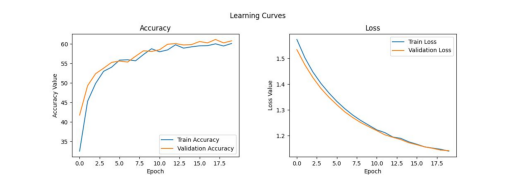

In [8]:
"efficientnet_b0 - transfer learn"

arg_dict = {"epochs": 20,
            "step_size": 2,
            "batch_size": 128,
            "lr": 5e-5,
            "weight_decay": 0.15,
            "gamma": 0.9}

def main():
  torch.cuda.empty_cache()
  loaders, dataset_sizes = load_img(r"/kaggle/working/images", batch_size=arg_dict["batch_size"])
  plotter = Plotter(model_name="EfficientNetb0_transferlearn")

  model = models.efficientnet_b0(pretrained=True)
  for param in model.parameters():
      param.requires_grad = False

  model.classifier = nn.Sequential(nn.Linear(model.classifier[1].in_features, 320),
                                   nn.Linear(320, len(classes))
                                   )
  model.to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.classifier.parameters(), lr = arg_dict["lr"], weight_decay=arg_dict["weight_decay"])
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=arg_dict["step_size"], gamma=arg_dict["gamma"], verbose=True)

  model, losses, accuracies = train(model, criterion, optimizer, arg_dict["epochs"], scheduler=None, device=device, loaders=loaders, dataset_sizes=dataset_sizes)
  plotter.plot_learnining_curves(losses, accuracies)
  actuals, predictions = evaluate_model(model, loaders, dataset="val", numclasses=len(classes), device=device)
  plotter.plot_confusion_matrix(actuals, predictions, [classes[drone] for drone in classes.keys()])
  return model

model = main()

plt.imshow(Image.open(r"/kaggle/working/EfficientNetb0_transferlearn_learning_curve.jpg"))
plt.axis("off")
plt.show()

torch.save(model, "/kaggle/working/EfficientNetb0_transferlearn.pth")

Train set size: 4560
Validation set size: 1140

Adjusting learning rate of group 0 to 2.5000e-05.
Epoch: 1/60
train - loss: 1.1421366407160174, accuracy: 58.44298245614035
val - loss: 1.1005142571633322, accuracy: 59.82456140350877


Epoch: 2/60
train - loss: 1.0964411973953248, accuracy: 59.25438596491228
val - loss: 1.051514833224447, accuracy: 62.01754385964912


Epoch: 3/60
train - loss: 1.0555731919773839, accuracy: 60.526315789473685
val - loss: 1.0305155239607158, accuracy: 61.140350877192986


Epoch: 4/60
train - loss: 1.0236776107235959, accuracy: 61.030701754385966
val - loss: 1.005943529229415, accuracy: 62.36842105263158


Epoch: 5/60
train - loss: 1.0017823704502038, accuracy: 62.28070175438597
val - loss: 0.9747728717954536, accuracy: 61.40350877192983


Epoch: 6/60
train - loss: 0.9601177725875587, accuracy: 63.530701754385966
val - loss: 0.9621155600798758, accuracy: 61.75438596491228


Epoch: 7/60
train - loss: 0.9524397456855105, accuracy: 63.44298245614035
val - loss

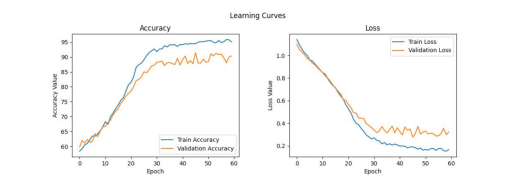

In [9]:
"efficientnet_b0 - finetune"

arg_dict = {"epochs": 60,
            "step_size": 2,
            "batch_size": 32,
            "lr": 2.5e-5,
            "weight_decay": 0.15,
            "gamma": 0.9}

def main():
  torch.cuda.empty_cache()
  loaders, dataset_sizes = load_img(r"/kaggle/working/images", batch_size=arg_dict["batch_size"])
  plotter = Plotter(model_name="EfficientNetb0_finetune")

  model = torch.load("/kaggle/working/EfficientNetb0_transferlearn.pth")
  for param in model.parameters():
      param.requires_grad = True
  model.to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = arg_dict["lr"], weight_decay=arg_dict["weight_decay"])
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=arg_dict["step_size"], gamma=arg_dict["gamma"], verbose=True)

  model, losses, accuracies = train(model, criterion, optimizer, scheduler=None, epochs=arg_dict["epochs"], device=device, loaders=loaders, dataset_sizes=dataset_sizes)
  plotter.plot_learnining_curves(losses, accuracies)
  actuals, predictions = evaluate_model(model, loaders, dataset="val", numclasses=len(classes), device=device)
  plotter.plot_confusion_matrix(actuals, predictions, [classes[drone] for drone in classes.keys()])
  return model

model = main()

plt.imshow(Image.open(r"/kaggle/working/EfficientNetb0_finetune_learning_curve.jpg"))
plt.axis("off")
plt.show()

torch.save(model, "/kaggle/working/EfficientNetb0_finetune.pth")